## Matched Filtering

In [4]:
!pip install -q 'lalsuite==7.11' 'PyCBC==2.0.5'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3

In [2]:
import numpy
import matplotlib.pyplot as plt

sample_rate = 1024
data_length = 1024

# Generate a long stretch of white noise: the data series and the time series.
data = numpy.random.normal(size=[sample_rate * data_length])
times = numpy.arange(len(data)) / float(sample_rate)

In [5]:
from pycbc.waveform import get_td_waveform

apx = 'IMRPhenomD'

In [9]:
# Generate a time domain waveform
hp1, _ = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

In [10]:
# Normalise the signal using the cross correlation of the signal with itself to change amplitude from order 10^-20 to 1

hp1 = hp1 / max(numpy.correlate(hp1, hp1, mode='full'))**0.5

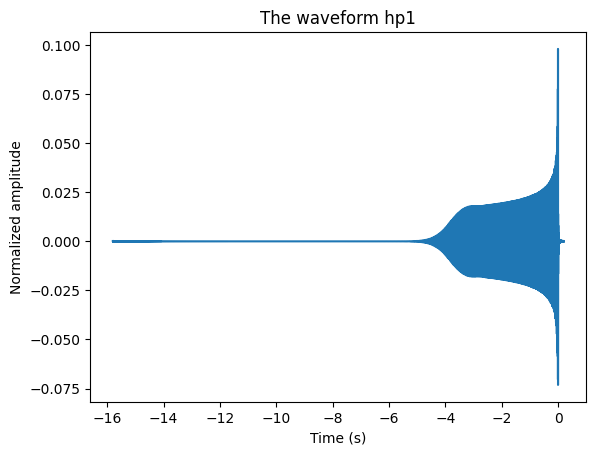

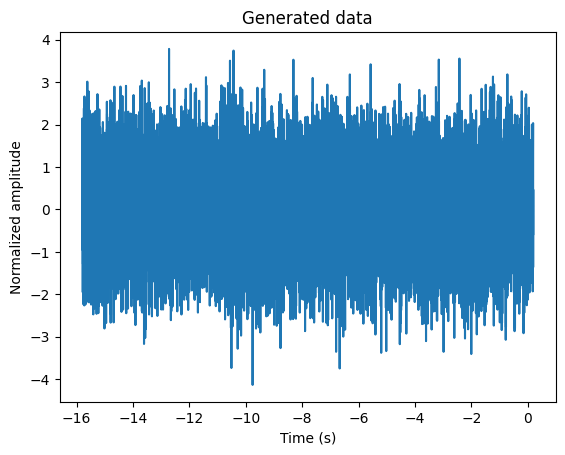

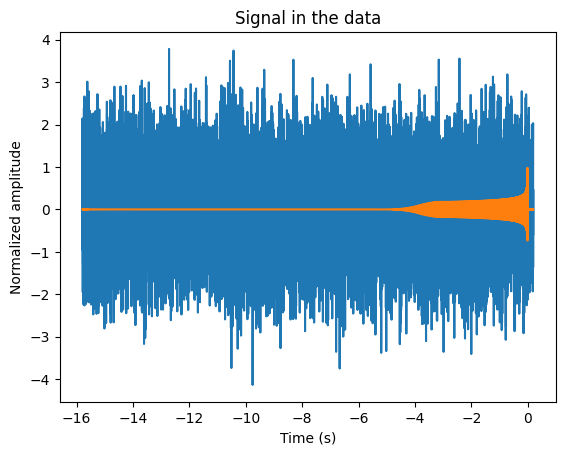

In [13]:
plt.figure()
plt.title("The waveform hp1")
plt.plot(hp1.sample_times, hp1)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')

# Shift the waveform to start at a random time in the Gaussian noise data.
waveform_start = numpy.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

plt.figure()
plt.title("Generated data")
plt.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')

plt.figure()
plt.title("Signal in the data")
plt.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
plt.plot(hp1.sample_times, 10 * hp1)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')
plt.show()

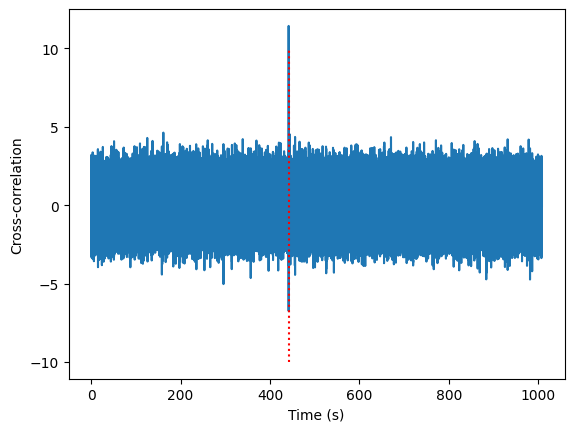

In [15]:
# Cross correlate the signal with the entire dataset to find it
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1_numpy = hp1.numpy()
for i in range(len(data) - len(hp1_numpy)):
    cross_correlation[i] = (hp1_numpy * data[i:i+len(hp1_numpy)]).sum()

plt.figure()
times = numpy.arange(len(data) - len(hp1_numpy)) / float(sample_rate)
plt.plot(times, cross_correlation)
plt.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-10,10],'r:')
plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')
plt.show()

### Detection in Colored Noise

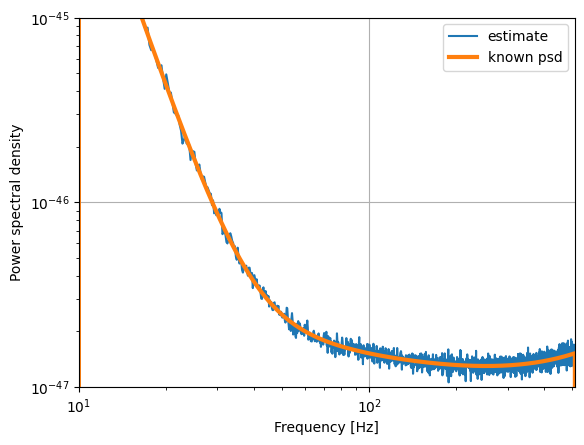

In [17]:
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD provided.
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate colored noise
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# Estimate the amplitude spectral density (ASD = sqrt(PSD)) for the noisy data
# using the "welch" method. We'll choose 4 seconds PSD samples that are overlapped 50%
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,seg_len=seg_len,seg_stride=seg_stride)

plt.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
plt.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
plt.xlim(xmin=flow, xmax=512)
plt.ylim(1e-47, 1e-45)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density')
plt.legend()
plt.grid()
plt.show()

# add the signal, this time, with a "typical" amplitude.
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20

In [18]:
# Generate a PSD for whitening the data
from pycbc.types import TimeSeries

# The PSD, sampled properly for the noisy data
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The PSD, sampled properly for the signal
delta_f = sample_rate / float(len(hp1))
flen = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The 0th and Nth values are zero. Set them to a nearby value to avoid dividing by zero.
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]

# Same, for the PSD sampled for the signal
psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

# convert both noisy data and the signal to frequency domain,
# and divide each by ASD=PSD**0.5, then convert back to time domain.
# This "whitens" the data and the signal template.
# Multiplying the signal template by 1E-21 puts it into realistic units of strain.
data_whitened = (ts.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() * 1E-21

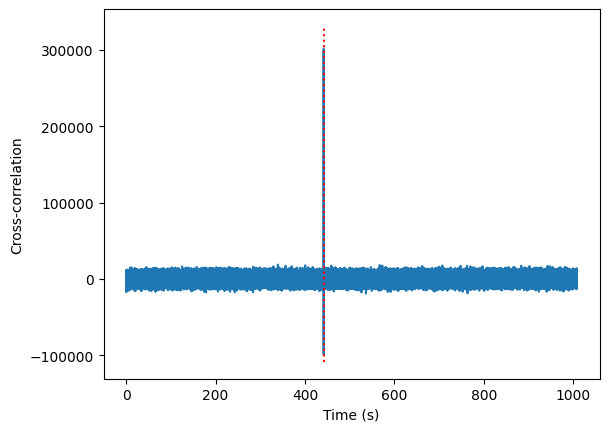

In [19]:
#Re-do the correlation, in the time domain, but with whitened data and template.
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
for i in range(len(datan) - len(hp1n)):
    cross_correlation[i] = (hp1n * datan[i:i+len(hp1n)]).sum()

plt.figure()
times = numpy.arange(len(datan) - len(hp1n)) / float(sample_rate)
plt.plot(times, cross_correlation)
plt.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')
plt.show()

In [53]:
data_whitened.data.std()

22.474998821344858

In [57]:
cross_correlation.std()

3986.5100687037016

In [56]:
# Signal To Noise Ratio
snr=cross_correlation.max()/cross_correlation.std()
snr

75.55760974886239

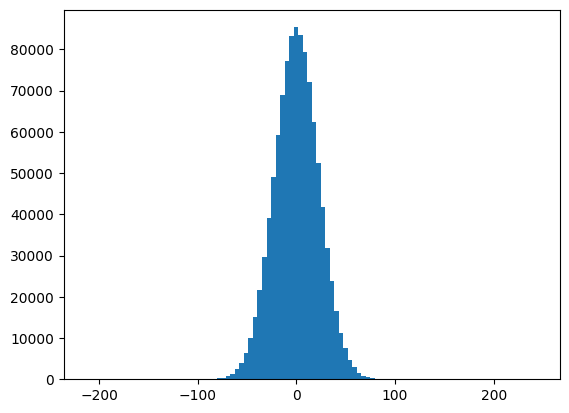

In [58]:
plt.hist(data_whitened.data,bins=100)
plt.show()

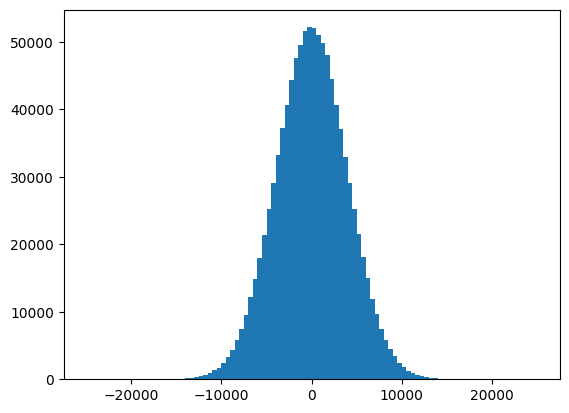

In [39]:
cc_hist=np.histogram(cross_correlation,bins=100)

plt.hist(cross_correlation,range=[-25000,25000],bins=100)
plt.show()